In [6]:
import numpy as np
import pandas as pd
import warnings
import os

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.compat.v1.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D

warnings.simplefilter('ignore')

countryName = 'Brazil'

nFeatures = 1

nDaysMin = 3
k = 3

nValid = 10
nTest = 10

In [7]:
dataDir = os.path.join('C:\\Users\\AMC\\Desktop\\Roshi\\Data')
confirmedFilename = 'confirmed_july.csv'
deathsFilename = 'deaths_july.csv'
recoveredFilename = 'recovered_july.csv'

In [8]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, k):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix + k >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+k]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
def meanAbsolutePercentageError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    absPcErrorList = [absError/yTrue for absError, yTrue in zip(absErrorList, yTrueList)]
    MAPE = 100*np.mean(absPcErrorList)
    return MAPE

def meanAbsolutePercentageError_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
            
    # Get MAPE for each day in a list
    MAPEList = []
    for i in yTrueForDayK.keys():
        MAPEList.append(meanAbsolutePercentageError(yTrueForDayK[i], yPredForDayK[i]))
    return np.mean(MAPEList)

def meanForecastError(yTrueList, yPredList):
    forecastErrors = [yTrue - yPred for yTrue, yPred in zip(yTrueList, yPredList)]
    MFE = np.mean(forecastErrors)
    return MFE

def meanAbsoluteError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(absErrorList)

def meanSquaredError(yTrueList, yPredList):
    sqErrorList = [np.square(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(sqErrorList)

def rootMeanSquaredError(yTrueList, yPredList):
    return np.sqrt(meanSquaredError(yTrueList, yPredList))
def medianSymmetricAccuracy(yTrueList, yPredList):
    '''https://helda.helsinki.fi//bitstream/handle/10138/312261/2017SW001669.pdf?sequence=1'''
    logAccRatioList = [np.abs(np.log(yPred/yTrue)) for yTrue, yPred in zip(yTrueList, yPredList)]
    MdSA = 100*(np.exp(np.median(logAccRatioList))-1)
    return MdSA

def medianSymmetricAccuracy_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
    # Get MdSA for each day in a list
    MdSAList = []
    for i in yTrueForDayK.keys():
        MdSAList.append(medianSymmetricAccuracy(yTrueForDayK[i], yPredForDayK[i]))
    return(np.mean(MdSAList))

In [10]:
# Get all the frames for a country
def getCountryCovidFrDict(countryName):
    countryCovidFrDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryCovidFrDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryCovidFrDict

In [11]:
# Load all 3 csv files
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(confirmedFilename)
covidFrDict['deaths'] = pd.read_csv(deathsFilename)
covidFrDict['recovered'] = pd.read_csv(recoveredFilename)

countryCovidFrDict = getCountryCovidFrDict(countryName)

# List of dates
colNamesList = list(countryCovidFrDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName]
dataList = [countryCovidFrDict['confirmed'][date].iloc[0] for date in dateList]
dataDict = dict(zip(dateList, dataList))

# Only take time series from where the cases were >100
daysSince = 100
nCasesGreaterDaysSinceList = []
datesGreaterDaysSinceList = []

for key in dataDict.keys():
    if dataDict[key] > daysSince:
        datesGreaterDaysSinceList.append(key)
        nCasesGreaterDaysSinceList.append(dataDict[key])
        
XList, yList = split_sequence(nCasesGreaterDaysSinceList, nDaysMin, k)

XTrainList = XList[0:len(XList)-(nValid + nTest)]
XValidList = XList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
XTestList = XList[-nTest:]

yTrain = yList[0:len(XList)-(nValid + nTest)]
yValid = yList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
yTest = yList[-nTest:]
print('Total size of data points for LSTM:', len(yList))
print('Size of training set:', len(yTrain))
print('Size of validation set:', len(yValid))
print('Size of test set:', len(yTest))

# Convert the list to matrix
XTrain = XTrainList.reshape((XTrainList.shape[0], XTrainList.shape[1], nFeatures))
XValid = XValidList.reshape((XValidList.shape[0], XValidList.shape[1], nFeatures))
XTest = XTestList.reshape((XTestList.shape[0], XTestList.shape[1], nFeatures))
yTest

Total size of data points for LSTM: 132
Size of training set: 112
Size of validation set: 10
Size of test set: 10


array([[2012151, 2046328, 2074860],
       [2046328, 2074860, 2098389],
       [2074860, 2098389, 2118646],
       [2098389, 2118646, 2159654],
       [2118646, 2159654, 2227514],
       [2159654, 2227514, 2287475],
       [2227514, 2287475, 2343366],
       [2287475, 2343366, 2394513],
       [2343366, 2394513, 2419091],
       [2394513, 2419091, 2442375]], dtype=int64)

# Vanilla LSTM

In [12]:
nNeurons = 100 # number of neurones
nFeatures = 1  # number of features

bestValidMAPE = 100 # 100 validation for best MAPE
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    
    # define model
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)
    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')
model.summary()

# fit model
model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)


yPredVanilla = yPredListList    
        

0 3.161702241539039
Updating best MAPE to 3.161702241539039...
Updating best seed to 0...
1 1.2405003289337762
Updating best MAPE to 1.2405003289337762...
Updating best seed to 1...
2 1.0757802264425698
Updating best MAPE to 1.0757802264425698...
Updating best seed to 2...
3 2.748849809472509
4 29.362222348017884
5 1.537657582810988
6 3.4579393609586737
7 3.6416725622420247
8 3.1362231194066026
9 0.9419317784407077
Updating best MAPE to 0.9419317784407077...
Updating best seed to 9...
10 0.7590617268552501
Updating best MAPE to 0.7590617268552501...
Updating best seed to 10...
11 7.771088467920826
12 5.219810053290164
13 6.2761162047520935
14 1.1666082903623558
15 6.5686739362716935
16 1.0472073329809437
17 99.97892376777833
18 2.668611887504257
19 3.2298917603072184
20 99.97907686553783
21 1.0088896787316408
22 99.99175903494863
23 1.0682879686093154
24 99.978754380937
25 3.566704814647995
26 3.233450853976418
27 0.9880667077234074
28 7.036126282155169
29 3.8049323569029987
30 4.43710

# Stacked LSTM

In [13]:
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
    model.add(LSTM(nNeurons, activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)
        
        
#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)

    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
        
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
model.add(LSTM(nNeurons, activation='relu'))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
yPredStacked = yPredListList

0 2.0772567336890475
Updating best MAPE to 2.0772567336890475...
Updating best seed to 0...
1 2.1436732757064543
2 78.41553370918783
3 4.349607063793617
4 77.96079301127428
5 76.98344969868657
6 78.48150163880342
7 2.9235943273347815
8 4.25124680949897
9 77.91993019607901
10 2.7516720658579814
11 78.02470699436337
12 4.374526209979116
13 4.676856775385455
14 78.63951768400398
15 4.325131918247789
16 1.2195919373210125
Updating best MAPE to 1.2195919373210125...
Updating best seed to 16...
17 0.982045322876898
Updating best MAPE to 0.982045322876898...
Updating best seed to 17...
18 78.68287858826378
19 77.50534781140384
20 78.30279127404306
21 77.98674557007753
22 1.497332956991114
23 79.33421276945212
24 78.90331963294891
25 78.0542348155131
26 3.0611680091056317
27 6.623887434223588
28 1.9677385448151785
29 78.0982798013832
30 4.584611681863595
31 78.06905658373658
32 78.52020500234822
33 3.691670215857176
34 2.560219755336608
35 1.2859065954305977
36 6.0201988272106135
37 78.9287514

# Bi-directional LSTM

In [14]:
# define model
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
yPredBidirectional = yPredListList

0 3.9366393542535376
Updating best MAPE to 3.9366393542535376...
Updating best seed to 0...
1 3.028569673239828
Updating best MAPE to 3.028569673239828...
Updating best seed to 1...
2 3.6896275271549137
3 3.4184339657528153
4 8.954063881696754
5 2.1070965469170795
Updating best MAPE to 2.1070965469170795...
Updating best seed to 5...
6 1.9620487023558517
Updating best MAPE to 1.9620487023558517...
Updating best seed to 6...
7 5.731498035246903
8 5.279818919024655
9 2.742302082717964
10 2.6271541631456397
11 3.1009159275034364
12 7.165428879441369
13 6.862305287017988
14 1.1318860504475192
Updating best MAPE to 1.1318860504475192...
Updating best seed to 14...
15 3.5636701666994424
16 3.581852107378111
17 2.5281645727544753
18 3.1060607258295234
19 5.3008371885697265
20 3.364305443610428
21 99.98722193406257
22 2.890469977468562
23 3.931882149215721
24 1.0871315623504036
Updating best MAPE to 1.0871315623504036...
Updating best seed to 24...
25 5.1953668976301355
26 2.029201675448916
27

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Format y tick labels
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

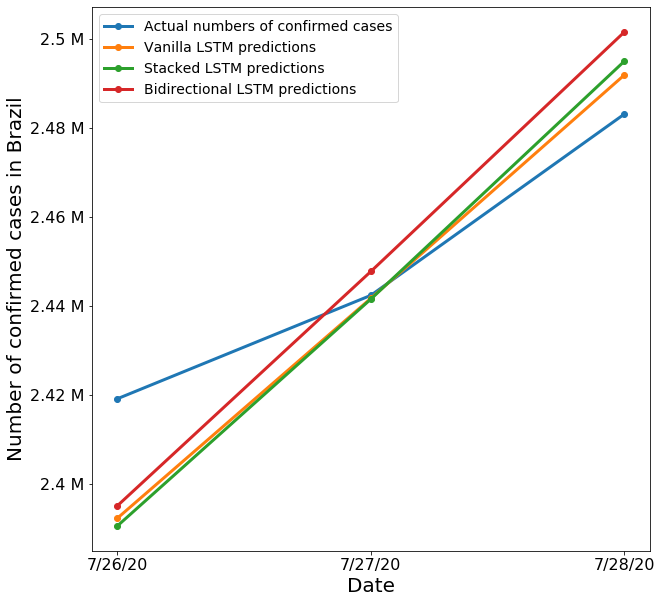

In [16]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in Brazil', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
plt.savefig(os.path.join('Plots_3days_k3', 'predictions_{}.png'.format(countryName)), dpi=400)
plt.savefig(os.path.join('Plots_3days_k3', 'predictions_{}.pdf'.format(countryName)), dpi=400)

In [17]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla)
print('Test RMSE:', RMSE)

Test RMSE: 357724.5517846244


In [18]:

RMSE = rootMeanSquaredError(groundTruthList, yPredStacked)
print('Test RMSE:', RMSE)


Test RMSE: 353136.842587148


In [19]:
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional)
print('Test RMSE:', RMSE)

Test RMSE: 352110.3604448873


In [20]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional[-1])
print('Test RMSE:', RMSE)
#Test RMSE: 16347.539257994356
#Test RMSE: 17914.42708696448
#Test RMSE: 17804.357910471434

Test RMSE: 16347.539257994356
Test RMSE: 17914.42708696448
Test RMSE: 17804.357910471434


In [22]:
groundTruthList
#[2419091, 2442375, 2483191]

[2419091, 2442375, 2483191]

In [23]:
 yPredVanilla[-1]
    #[2392188.5, 2441698.2, 2491995.8]

[2392188.5, 2441698.2, 2491995.8]

In [24]:
yPredStacked[-1]
#[2390450.0, 2441526.2, 2495097.0]

[2390450.0, 2441526.2, 2495097.0]

In [25]:
yPredBidirectional[-1]
#[2394990.2, 2447748.0, 2501664.5]

[2394990.2, 2447748.0, 2501664.5]